In [2]:
%matplotlib inline
import importlib
from scipy.misc import imread, imresize, imsave, fromimage, toimage
from scipy.optimize import fmin_l_bfgs_b
import numpy as np
import time
import random
from PIL import Image
import os
import pickle
#import bcolz
#from bcolz_array_iterator import BcolzArrayIterator
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, AveragePooling2D, MaxPooling2D
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.utils.layer_utils import convert_all_kernels_in_model
import keras.backend as K

from keras.layers import Conv2D, UpSampling2D, Lambda, ZeroPadding2D
from keras.models import Sequential

from vgg16_avg import VGG16_Avg
#from vgg16 import VGG16

import sys
#sys.path.append('../utilities')
#import utils2; importlib.reload(utils2)
#from utils2 import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.transform as trans
import random as r
from keras.optimizers import Adam
from skimage.color import rgb2grey

from skimage import feature
import skimage

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Example of Image

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/ndimage/measurements.py:431: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  safe = ((np.issubdtype(dt, int) and dt.itemsize <= int_size) or
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


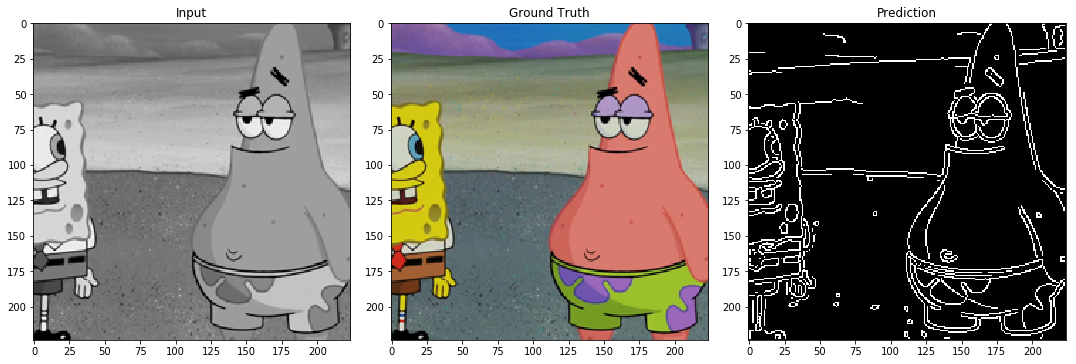

In [3]:
file ='images/Spongebob/img/frame_0001.png'

img = io.imread(file)/255
greyscale = rgb2grey(img)
canny = feature.canny(greyscale)

plt.figure(figsize=(15,10))

plt.subplot(131)
plt.title('Input')
plt.imshow(greyscale,cmap = 'gray')

plt.subplot(132)
plt.title('Ground Truth')
skimage.io.imshow(img)

plt.subplot(133)
plt.title('Prediction')
plt.imshow(canny,cmap = 'gray')

In [4]:
np.array(greyscale).shape

(224, 224)

# Data loading and Prepocessing

In [5]:
import glob
def create_data(src, mask, label=False):
    files = glob.glob(src + mask, recursive=True)
    imgs = []
    imgs_grey = []
    for file in files:
        feat_grey = []
        img = io.imread(file)
        if label:
            img[img == 4] = 1
            img[img != 1] = 0
            img = img.astype('float32')
        else:
            img = img/255
        imgs.append(img)
        img_grey = rgb2grey(img)
        feat_grey.append(img_grey)
        canny = feature.canny(img_grey)
        feat_grey.append(canny)
        imgs_grey.append(feat_grey)
    name = 'y'
    np.save(name, np.array(imgs).astype('float32'))
    print('Saved', len(files), 'to', name)
    name = 'x'
    np.save(name, np.array(imgs_grey).transpose(0,2,3,1).astype('float32'))
    print('Saved', len(files), 'to', name)

In [6]:
create_data('images/Spongebob/img/', '**.png')

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/ndimage/measurements.py:431: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  safe = ((np.issubdtype(dt, int) and dt.itemsize <= int_size) or


Saved 1742 to y
Saved 1742 to x


In [7]:
x = np.load('x.npy')
print('x: ', x.shape)
y = np.load('y.npy')
print('y:', y.shape)

x:  (1742, 224, 224, 2)
y: (1742, 224, 224, 3)


# Models

## Fully Convolutional Network

In [13]:
def colorization_net(arr):
    inputs = Input(arr.shape[1:])
    conv1 = Conv2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Conv2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Conv2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Conv2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Conv2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    up1 = UpSampling2D(size=(2, 2))(pool4)
    conv5 = Convolution2D(128, 2, 2, activation='relu', border_mode='same')(up1)
    
    up2 = UpSampling2D(size=(2, 2))(conv5)
    conv6 = Convolution2D(64, 2, 2, activation='relu', border_mode='same')(up2)
    
    up3 = UpSampling2D(size=(2, 2))(conv6)
    conv7 = Convolution2D(33, 2, 2, activation='relu', border_mode='same')(up3)

    up4 = UpSampling2D(size=(2, 2))(conv7)
    conv8 = Convolution2D(3, 2, 2, activation='relu', border_mode='same')(up4)
    
    #model = Model(input=inputs, output=conv8)
    outputs = conv8
    
    return Model(inputs=inputs, outputs = conv8) #model

# UNet

In [8]:
def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = Convolution2D(filters, size, size, subsample=stride, border_mode=mode)(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x) if act else x

def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return merge([x, ip], mode='sum')

In [9]:
from keras.models import Input, Model
from keras.layers import Conv2D, Concatenate, MaxPooling2D, Reshape
from keras.layers import UpSampling2D, Activation, Permute

def level_block(m, dim, depth, factor, acti):
    if depth > 0:
        n = Conv2D(dim, 3, activation=acti, padding='same')(m)
        n = Conv2D(dim, 3, activation=acti, padding='same')(n)
        m = MaxPooling2D()(n)
        m = level_block(m, int(factor*dim), depth-1, factor, acti)
        m = UpSampling2D()(m)
        m = Conv2D(dim, 2, activation=acti, padding='same')(m)
        m = Concatenate(axis=3)([n, m])
    m = Conv2D(dim, 3, activation=acti, padding='same')(m)
    return Conv2D(dim, 3, activation=acti, padding='same')(m)

def UNet(img_shape, n_out=1, dim=64, depth=4, factor=2, acti='relu', flatten=False):
    i = Input(shape=img_shape)
    o = level_block(i, dim, depth, factor, acti)
    o = Conv2D(n_out, (1, 1))(o)
    if flatten:
        o = Reshape(n_out, img_shape[0] * img_shape[1])(o)
        o = Permute((2, 1))(o)
    o = Activation('relu')(o)
    return Model(inputs=i, outputs=o)

# Training 

## Fully Convolutionnal

In [ ]:
model = colorization_net(x)
model.compile(optimizer=Adam(lr=0.01), loss='mse')
model.fit(x, y, validation_split=0.2, epochs=50, batch_size=8)

## U-Net

In [10]:
model_u = UNet(x.shape[1:], n_out = 3, dim=8, factor=1)
model_u.load_weights('unet.h5')

In [39]:
model_u.compile(optimizer=Adam(lr=0.001), loss='mse')

In [40]:
model_u.fit(x[:500], y[:500], validation_split=0.2, epochs=100, batch_size=8)

Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 82s 205ms/step - loss: 8114.6136 - val_loss: 1963.6841
Epoch 2/20
400/400 [==============================] - 84s 210ms/step - loss: 1615.7997 - val_loss: 1215.7995
Epoch 3/20
400/400 [==============================] - 83s 207ms/step - loss: 1165.4337 - val_loss: 995.5214
Epoch 4/20
400/400 [==============================] - 85s 212ms/step - loss: 1008.0957 - val_loss: 925.4209
Epoch 5/20
400/400 [==============================] - 80s 201ms/step - loss: 937.9732 - val_loss: 868.5740
Epoch 6/20
400/400 [==============================] - 78s 194ms/step - loss: 901.1843 - val_loss: 840.9958
Epoch 7/20
400/400 [==============================] - 80s 199ms/step - loss: 882.9988 - val_loss: 825.8709
Epoch 8/20
400/400 [==============================] - 78s 196ms/step - loss: 881.3233 - val_loss: 818.5375
Epoch 9/20
400/400 [==============================] - 79s 197ms/step - loss: 860.2011 - val_

In [16]:
model_u.compile(optimizer=Adam(lr=0.0001), loss='mse')
model_u.fit(x[:500], y[:500], validation_split=0.2, epochs=100, batch_size=8)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 400 samples, validate on 100 samples
Epoch 1/100
400/400 [==============================] - 89s 221ms/step - loss: 4943.4276 - val_loss: 1562.0436
Epoch 2/100
400/400 [==============================] - 87s 218ms/step - loss: 1193.7291 - val_loss: 681.7760
Epoch 3/100
400/400 [==============================] - 827s 2s/step - loss: 567.4516 - val_loss: 354.8290
Epoch 4/100
400/400 [==============================] - 90s 226ms/step - loss: 317.6017 - val_loss: 202.6936
Epoch 5/100
400/400 [==============================] - 81s 203ms/step - loss: 174.6864 - val_loss: 96.5619
Epoch 6/100
400/400 [==============================] - 85s 214ms/step - loss: 71.9874 - val_loss: 36.5320
Epoch 7/100
400/400 [==============================] - 78s 196ms/step - loss: 26.4420 - val_loss: 12.8508
Epoch 8/100
400/400 [==============================] - 79s 199ms/step - loss: 9.1540 - val_loss: 4.2256
Epoch 9/100
400/400 [====

400/400 [==============================] - 63s 156ms/step - loss: 0.2044 - val_loss: 0.1784
Epoch 76/100
400/400 [==============================] - 76s 190ms/step - loss: 0.2027 - val_loss: 0.1783
Epoch 77/100
400/400 [==============================] - 65s 163ms/step - loss: 0.2026 - val_loss: 0.1783
Epoch 78/100
400/400 [==============================] - 61s 152ms/step - loss: 0.2025 - val_loss: 0.1782
Epoch 79/100
400/400 [==============================] - 58s 144ms/step - loss: 0.2025 - val_loss: 0.1782
Epoch 80/100
400/400 [==============================] - 70s 175ms/step - loss: 0.2024 - val_loss: 0.1782
Epoch 81/100
400/400 [==============================] - 68s 171ms/step - loss: 0.2024 - val_loss: 0.1781
Epoch 82/100
400/400 [==============================] - 69s 172ms/step - loss: 0.2024 - val_loss: 0.1781
Epoch 83/100
400/400 [==============================] - 66s 164ms/step - loss: 0.2024 - val_loss: 0.1781
Epoch 84/100
400/400 [==============================] - 65s 163ms/st

In [42]:
model_u.save_weights('unet.h5')

# Results

## Fully Convolutional

In [ ]:
pred = model.predict(x[:50])
pred = np.clip(pred,0,255)/255

In [ ]:
import random as r
import skimage
for n in range(20):
    i = int(r.random() * pred.shape[0])
    plt.figure(figsize=(15,10))

    plt.subplot(131)
    plt.title('Input')
    plt.imshow(x[i,:,:,0],cmap = 'gray')

    plt.subplot(132)
    plt.title('Ground Truth')
    skimage.io.imshow(y[i]/255)

    plt.subplot(133)
    plt.title('Prediction')
    plt.imshow(pred[i])

    plt.show()

## U-Net

In [13]:
pred_u = model_u.predict(x[:50])
pred_u = np.clip(pred_u,0,255)/255

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


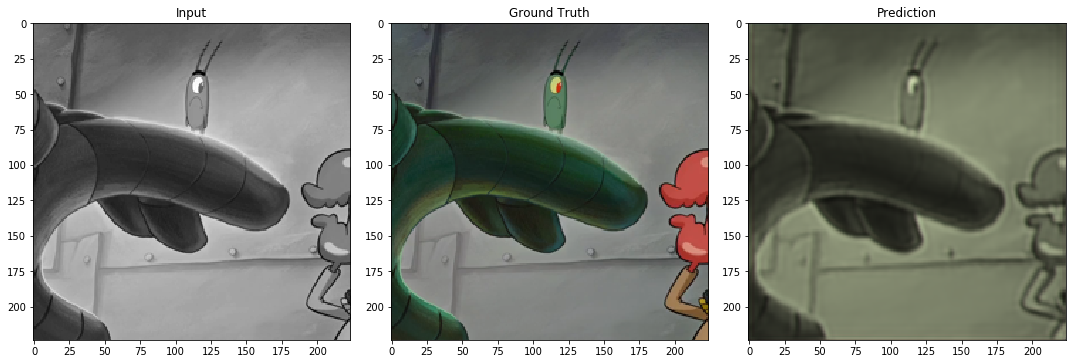

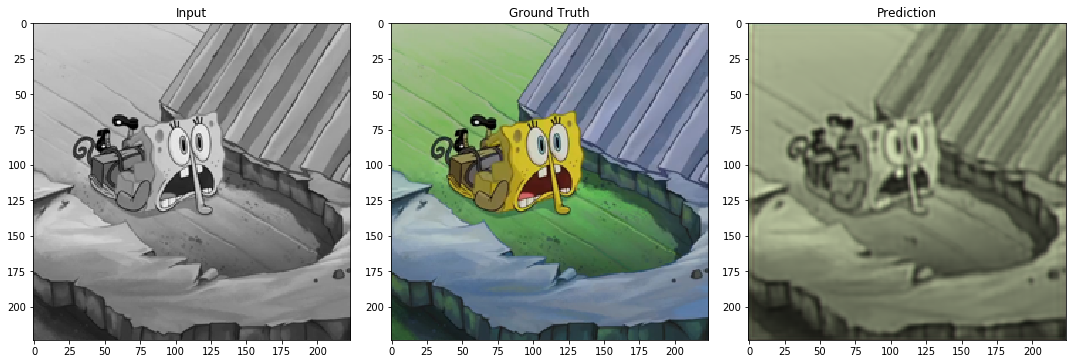

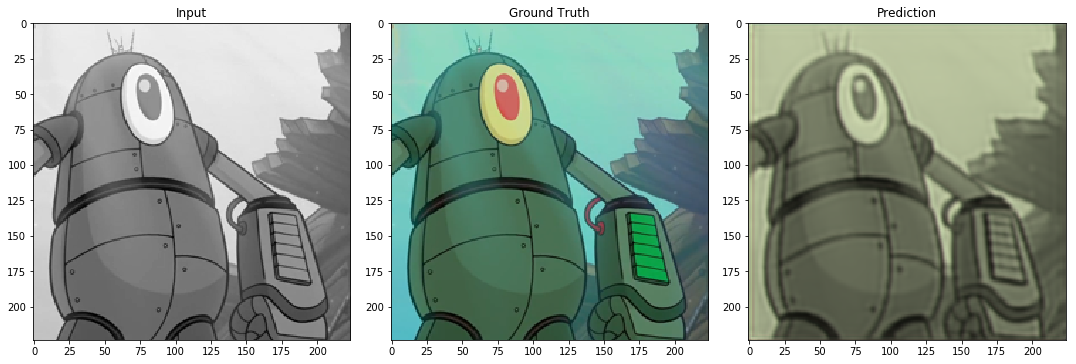

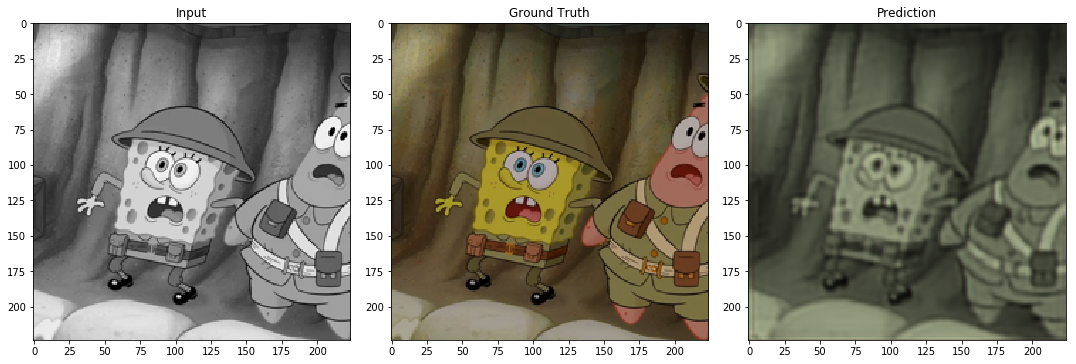

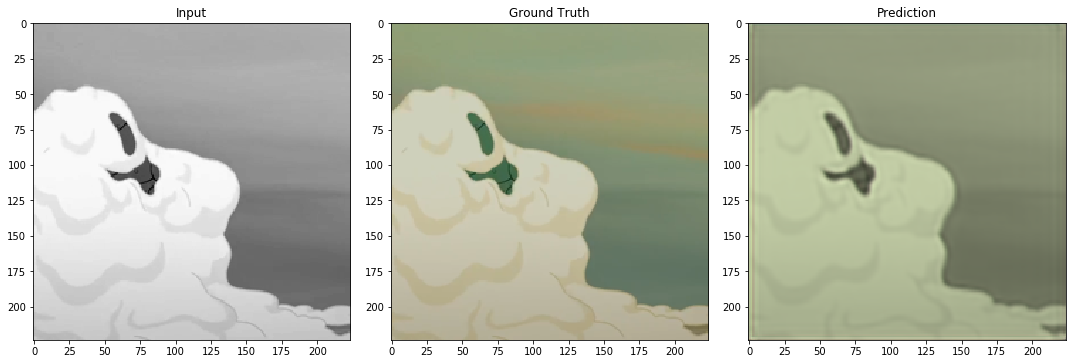

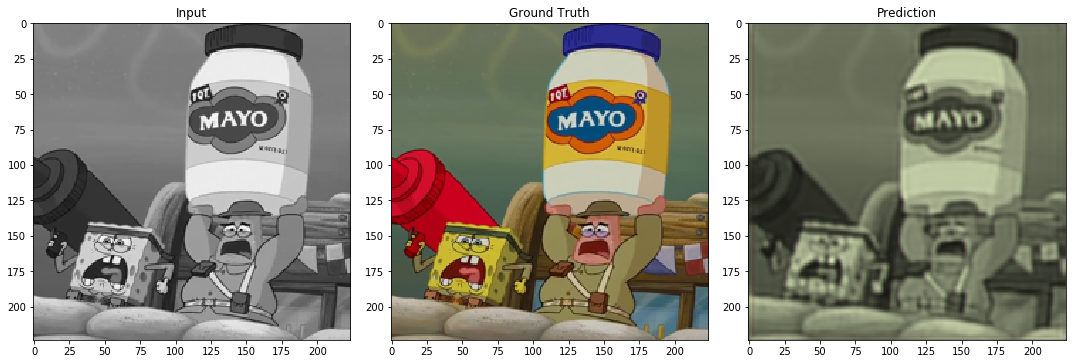

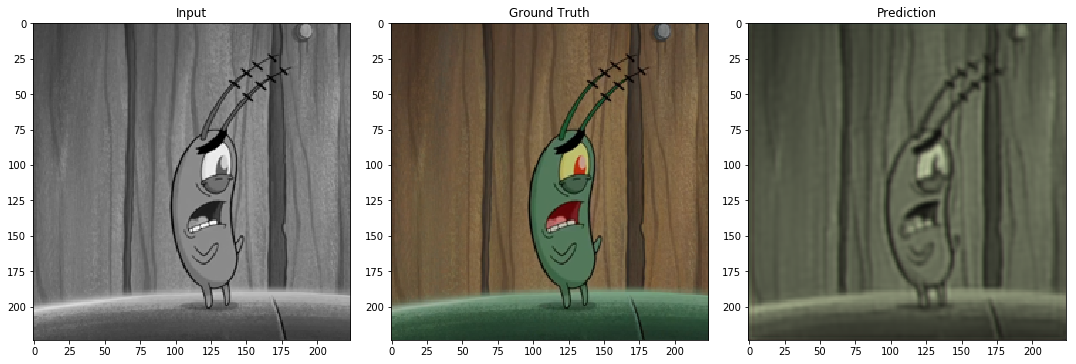

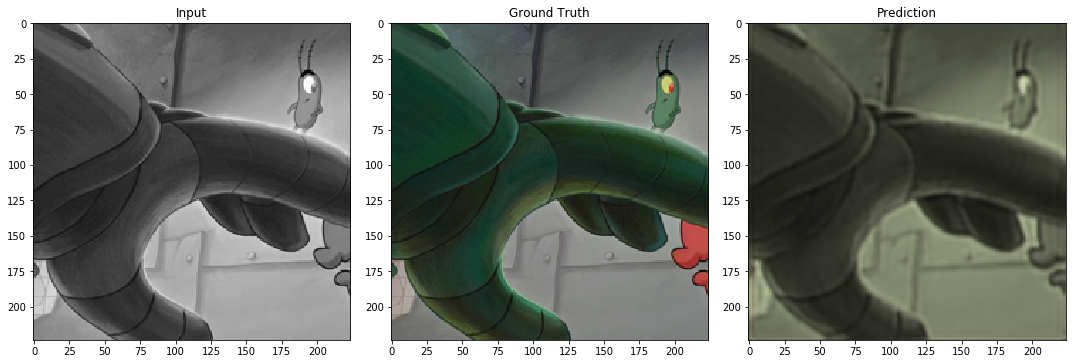

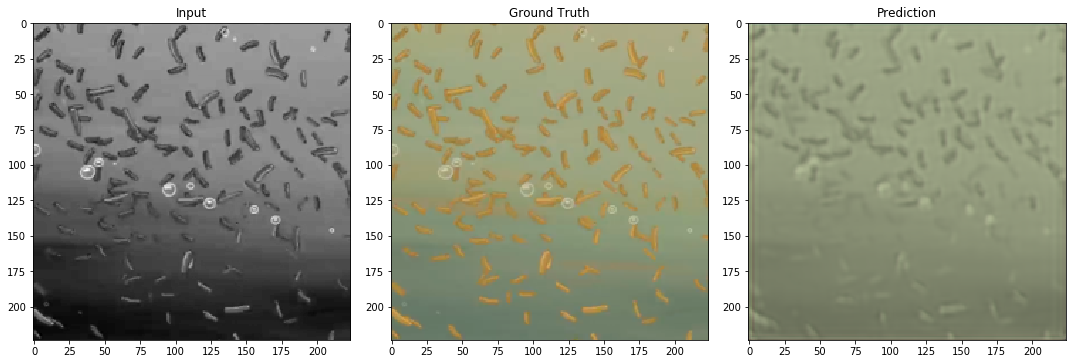

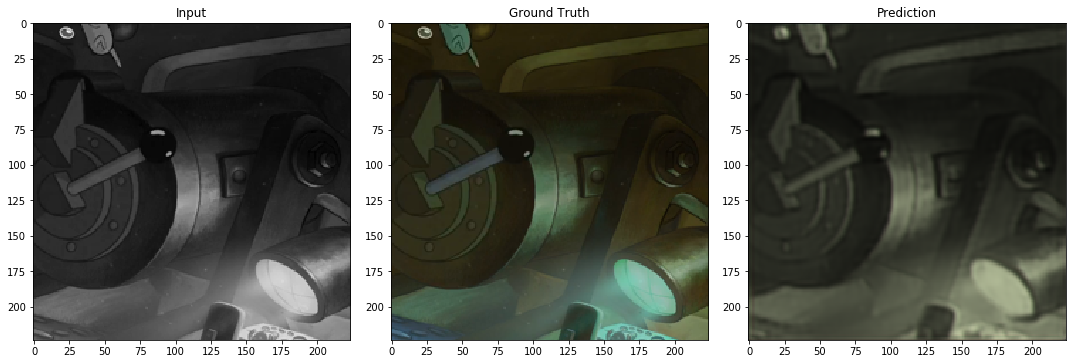

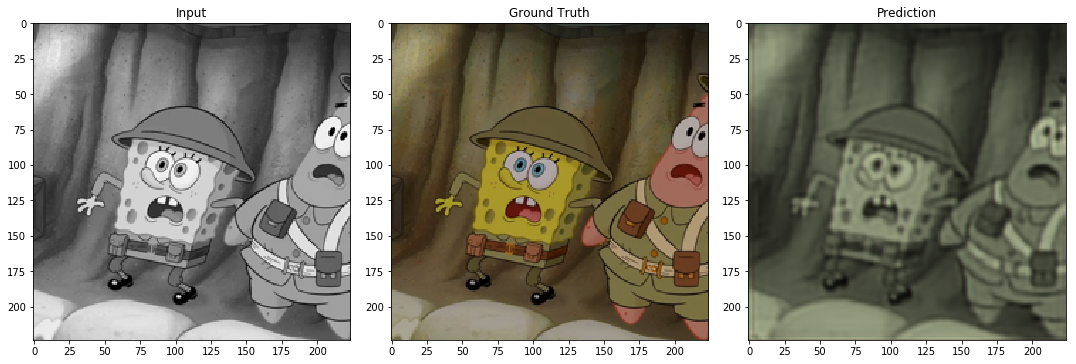

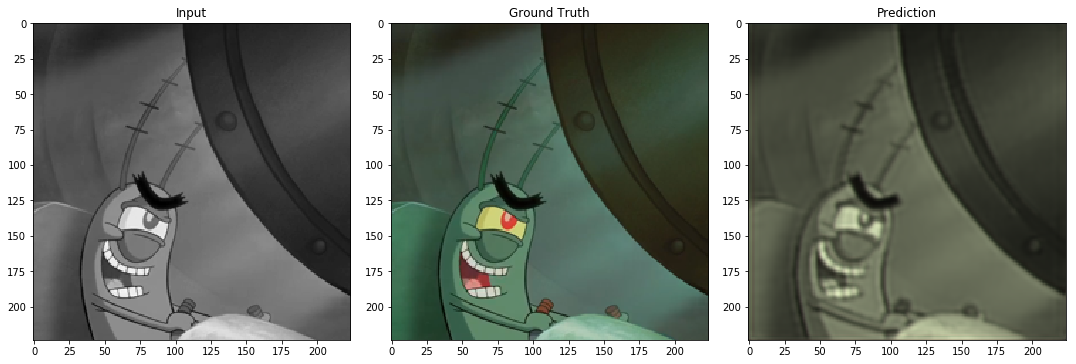

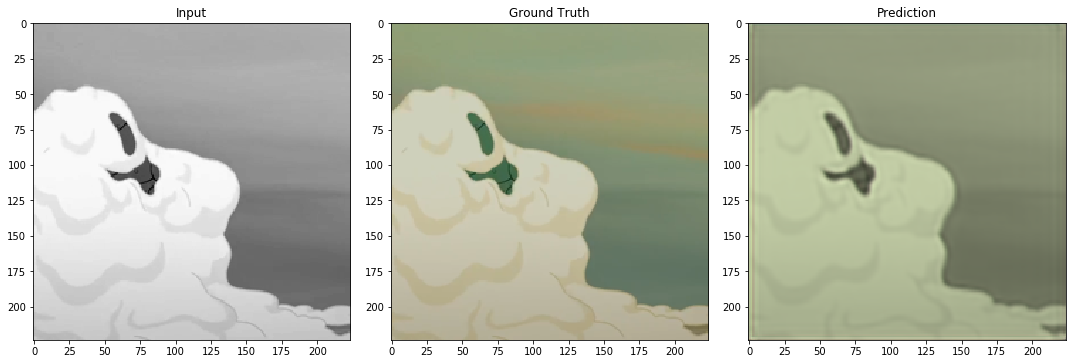

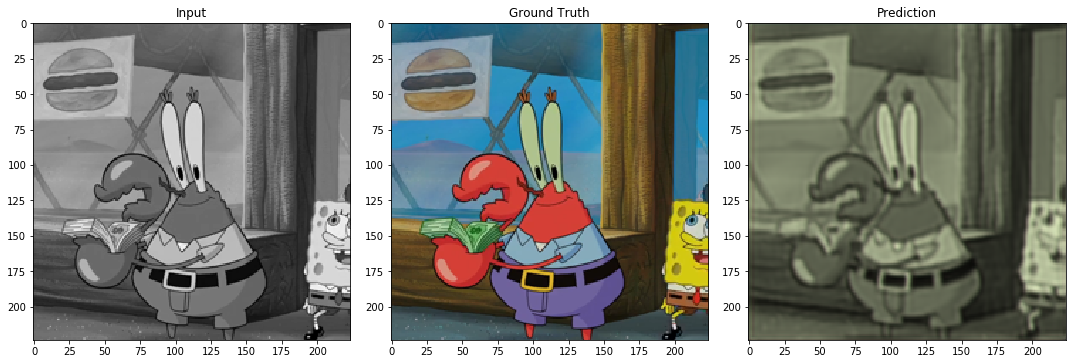

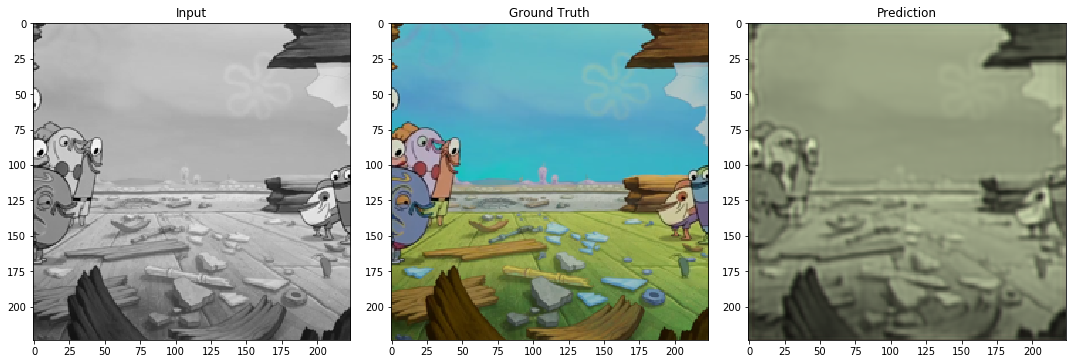

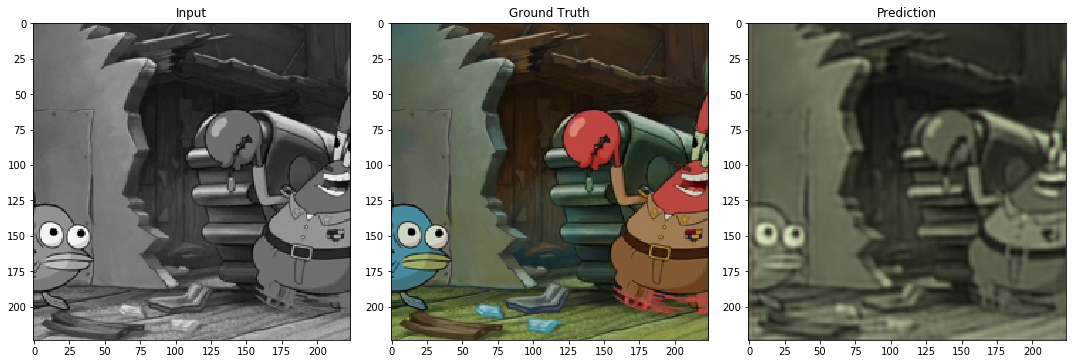

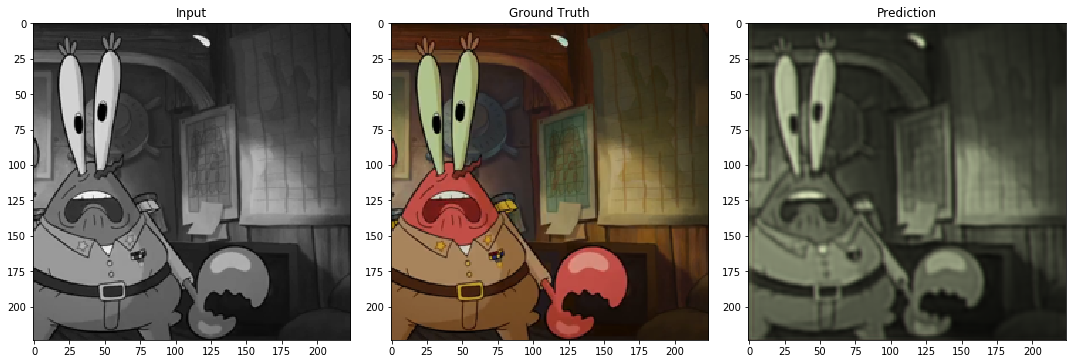

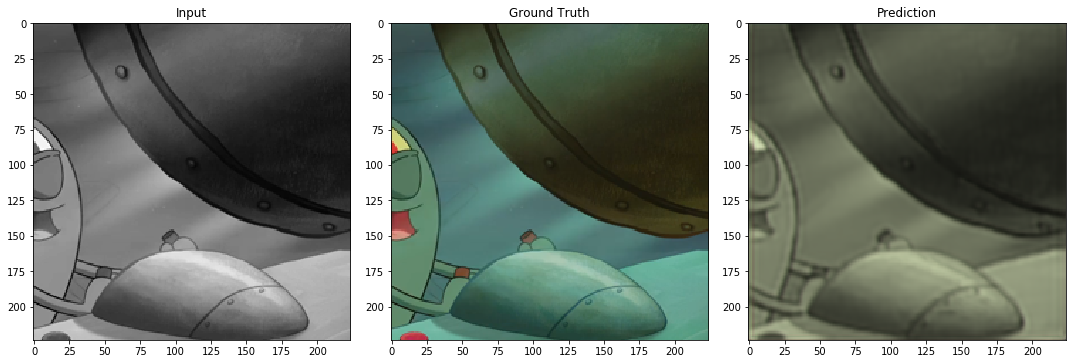

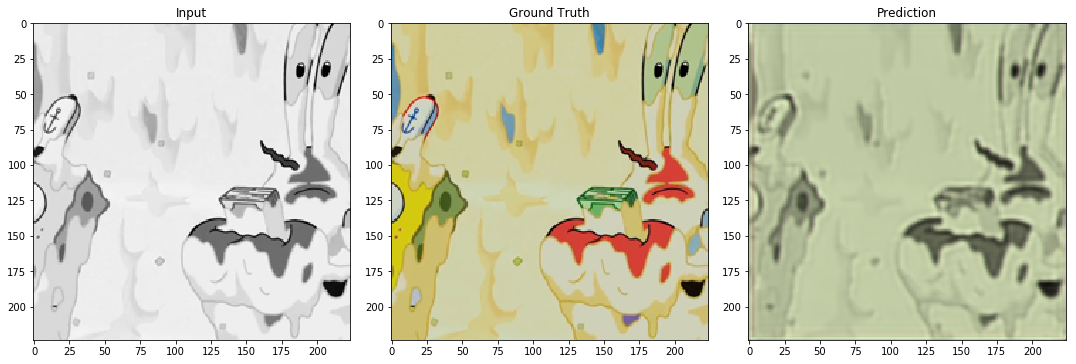

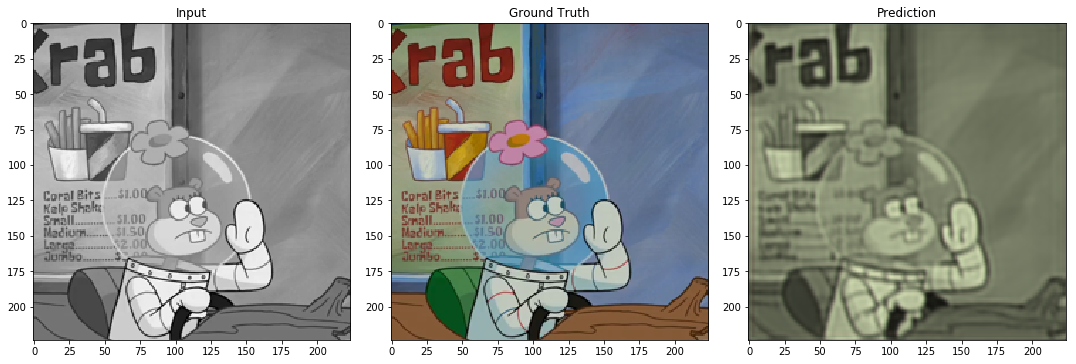

In [15]:
import random as r
import skimage
for n in range(20):
    i = int(r.random() * pred_u.shape[0])
    plt.figure(figsize=(15,10))

    plt.subplot(131)
    plt.title('Input')
    plt.imshow(x[i,:,:,0],cmap = 'gray')

    plt.subplot(132)
    plt.title('Ground Truth')
    skimage.io.imshow(y[i])

    plt.subplot(133)
    plt.title('Prediction')
    plt.imshow(pred_u[i])

    plt.show()